# Golf Swing Sequence Detection and Analysis
This notebook explores approaches to automating extractions of golf swing sequences from a golf range recordings.
I have been learning golf for some time, and recording my driving range session and reviewing the swings has been a very helpful way to improve.

Currently, I use tiktok or capcut to manually edit out swings from a full recording (Example is the video that I am using - "input_videos/ex.mp4") but I want to see if I can do this automatically using ML and computer vision techniques. So, let's dive in!

## Objectives of this notebook
- I need a way to find beginning and end frame of a golf swing sequence reliably
- this method needs to be tested on multiple videos that I have

In [3]:
from dotenv import load_dotenv
load_dotenv() 

True

I am using Roboflow's object detection model that has been trained to classify 12 different golf-specific objects from golf ball, golf club, club handle and more. I will probably only look at golf ball, golf club and golf club head. The reason is that only those classes have been detected when inferred on my video recording. 

I believe that simply analyzing the bounding boxes of the golf club head and golf ball can be an effective way to detect different stages of a golf swing sequence.

In [5]:
# import the InferencePipeline interface
from inference import InferencePipeline
# import a built-in sink called render_boxes (sinks are the logic that happens after inference)
from inference.core.interfaces.stream.sinks import render_boxes
from inference.core.interfaces.camera.entities import VideoFrame
import os
import json
from pprint import pprint

TARGET_DIR = "predictions"
api_key = os.getenv("ROBOFLOW_API_KEY")

arr = []

def save_prediction(prediction: dict, video_frame: VideoFrame) -> None:
    # pprint(prediction)
    # pprint(video_frame)
    # print("------------------------------------")
  # with open(os.path.join(TARGET_DIR, f"test.txt"), "a") as f:
    arr.append(prediction)
  #   json.dump(prediction, f)
  #   json.dump(video_frame, f)
    

# create an inference pipeline object
pipeline = InferencePipeline.init(
    model_id="golf-49wbh/1", # set the model id to a yolov8x model with in put size 1280
    video_reference="input_videos/01.mp4", # set the video reference (source of video), it can be a link/path to a video file, an RTSP stream url, or an integer representing a device id (usually 0 for built in webcams)
    on_prediction=save_prediction, # tell the pipeline object what to do with each set of inference by passing a function
    api_key=api_key, # provide your roboflow api key for loading models from the roboflow api
)
# start the pipeline
pipeline.start()
# wait for the pipeline to finish
pipeline.join()

In [4]:
len(arr)

794

I quickly want to check if the length of the array equals the number of frames when extracted using OpenCV

In [6]:
import cv2

def get_frame_count(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # Check if the video opened successfully
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    
    # Get the total number of frames
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Release the video capture object
    video.release()
    
    return frame_count

# Example usage
video_path = 'input_videos/ex.mp4'
frame_count = get_frame_count(video_path)
print(f'Total number of frames: {frame_count}')


Total number of frames: 794


Now let's look at what each prediction contains

In [7]:
arr[0]

{'image': {'width': 720, 'height': 1280},
 'predictions': [{'x': 473.5,
   'y': 1153.0,
   'width': 299.0,
   'height': 118.0,
   'confidence': 0.6775482892990112,
   'class': 'club',
   'class_id': 0,
   'detection_id': '693a4cec-642c-4782-b498-23766eb047bd'},
  {'x': 603.0,
   'y': 1161.5,
   'width': 38.0,
   'height': 117.0,
   'confidence': 0.6426902413368225,
   'class': 'club_head',
   'class_id': 1,
   'detection_id': '5722c5eb-719d-4690-81c8-f015296c0626'},
  {'x': 101.5,
   'y': 512.5,
   'width': 43.0,
   'height': 289.0,
   'confidence': 0.5648428797721863,
   'class': 'club',
   'class_id': 0,
   'detection_id': '518881c7-9509-48b7-b739-9a12cd32d309'}]}

In [6]:
num_preds = [len(x['predictions']) for x in arr]
print(set(num_preds))

{0, 1, 2, 3, 4}


Let's see what types of classes have been detected. When I tried the model on Roboflow's browser, only golf club, golf club head and golf ball were detected, but I want to check if this is true

In [7]:
def get_unique_classes(data):
    unique_classes = set()
    for item in data:
        for prediction in item['predictions']:
            unique_classes.add(prediction['class'])
    return unique_classes

# Assuming your array is named 'data'
unique_classes = get_unique_classes(arr)
print("Unique classes:", unique_classes)

Unique classes: {'golfball', 'club', 'club_head'}


I now want to visualize these predictions using Plotly.

In [8]:
#!pip install plotly

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def create_trajectory_plot(data):
    # Create a list to hold all predictions with frame numbers
    all_predictions = []
    for frame_num, frame_data in enumerate(data):
        for pred in frame_data['predictions']:
            pred['frame'] = frame_num
            all_predictions.append(pred)
    
    # Create a DataFrame
    df = pd.DataFrame(all_predictions)
    
    # Get unique classes
    classes = df['class'].unique()
    
    # Create subplots: one for x-coordinate over time, one for y-coordinate
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=("X-coordinate Trajectory", "Y-coordinate Trajectory"))
    
    # Color map for classes
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = dict(zip(classes, colors[:len(classes)]))
    
    for cls in classes:
        class_data = df[df['class'] == cls].sort_values('frame')
        
        # Add trace for x-coordinate
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['x'], mode='lines+markers',
                       name=f'{cls} (x)', line=dict(color=color_map[cls])),
            row=1, col=1
        )
        
        # Add trace for y-coordinate
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['y'], mode='lines+markers',
                       name=f'{cls} (y)', line=dict(color=color_map[cls], dash='dash')),
            row=2, col=1
        )
    
    # Update layout
    fig.update_layout(height=800, title_text="Object Trajectories in Golf Swing Video")
    fig.update_xaxes(title_text="Frame Number")
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    
    return fig

# Assuming your array is named 'data'
fig = create_trajectory_plot(arr)
fig.show()

Let's save this dataframe that the plot function is using since it may be useful later on:

In [10]:
all_predictions = []
for frame_num, frame_data in enumerate(arr):
    for pred in frame_data['predictions']:
        pred['frame'] = frame_num
        all_predictions.append(pred)

# Create a DataFrame
df = pd.DataFrame(all_predictions)
df.head(10)

,x,y,width,height,confidence,class,class_id,detection_id,frame
0,473.5,1153.0,299.0,118.0,0.677548,club,0,1227bef5-d21c-4b6b-8b26-d87eddd91f3c,0
1,603.0,1161.5,38.0,117.0,0.642690,club_head,1,471aedc6-e619-4183-8b5c-4d6f528334e3,0
2,101.5,512.5,43.0,289.0,0.564843,club,0,cf2af756-fa48-4b9a-a311-781ac6426a5d,0
3,473.5,1154.0,299.0,118.0,0.606155,club,0,2ffc77fb-c718-455f-8092-248b0fd4ca7a,1
4,603.0,1161.5,38.0,117.0,0.597305,club_head,1,46d9a707-5d26-431d-9e90-3c3d1a8cfdd7,1
5,101.5,512.5,45.0,289.0,0.557451,club,0,92d83e3a-8ef0-4bc2-a92b-2d6be36bea74,1
6,473.5,1154.0,299.0,118.0,0.609058,club,0,d243fc85-eae2-42d3-be7b-ff4a265934c1,2
7,603.0,1161.5,38.0,117.0,0.577448,club_head,1,8381976d-3dac-404b-b89d-f1a5328190ca,2
8,101.5,512.0,43.0,290.0,0.502902,club,0,11a209f6-af99-4ea7-9b5e-122e4c1ec5da,2
9,665.0,697.5,30.0,31.0,0.408816,club_head,1,bc5bb683-2165-453d-91ed-23549ca44336,2


The resulting plot provides a great visual representation of the object trajectories throughout the golf swing video. Here are some observations:
- Golf ball positions might be the best way to detect when the ball has been hit. However, it is not clear just from this example that golf ball can be reliably detected.
- Also, just looking at golf ball will be hard to find the beginning and the end of a swing sequence, which is all that we are interested in.
- I do see distinct patterns in the trajectories, likely corresponding to different phases of the golf swing.

Next, I want to see what each frame number looks like. To do so, I will need a tool to visualize different frame numbers

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Calculate the frame positions to be plotted
    frame_positions = np.linspace(start_frame, end_frame, num_frames, dtype=int)
    
    # Calculate the number of rows and columns for the subplots
    cols = math.ceil(math.sqrt(num_frames))
    rows = math.ceil(num_frames / cols)
    
    # Create subplots with adjusted figure size for better visualization
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Read and plot specific frames
    for i, frame_position in enumerate(frame_positions):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)
        
        # Read the frame
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Could not read frame at position {frame_position}.")
            continue
        
        # Convert the frame from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Plot the frame
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {frame_position}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(len(frame_positions), len(axes)):
        axes[j].axis('off')
    
    # Release the video capture object
    cap.release()
    
    # Adjust layout
    plt.tight_layout(pad=2.0)
    plt.show()



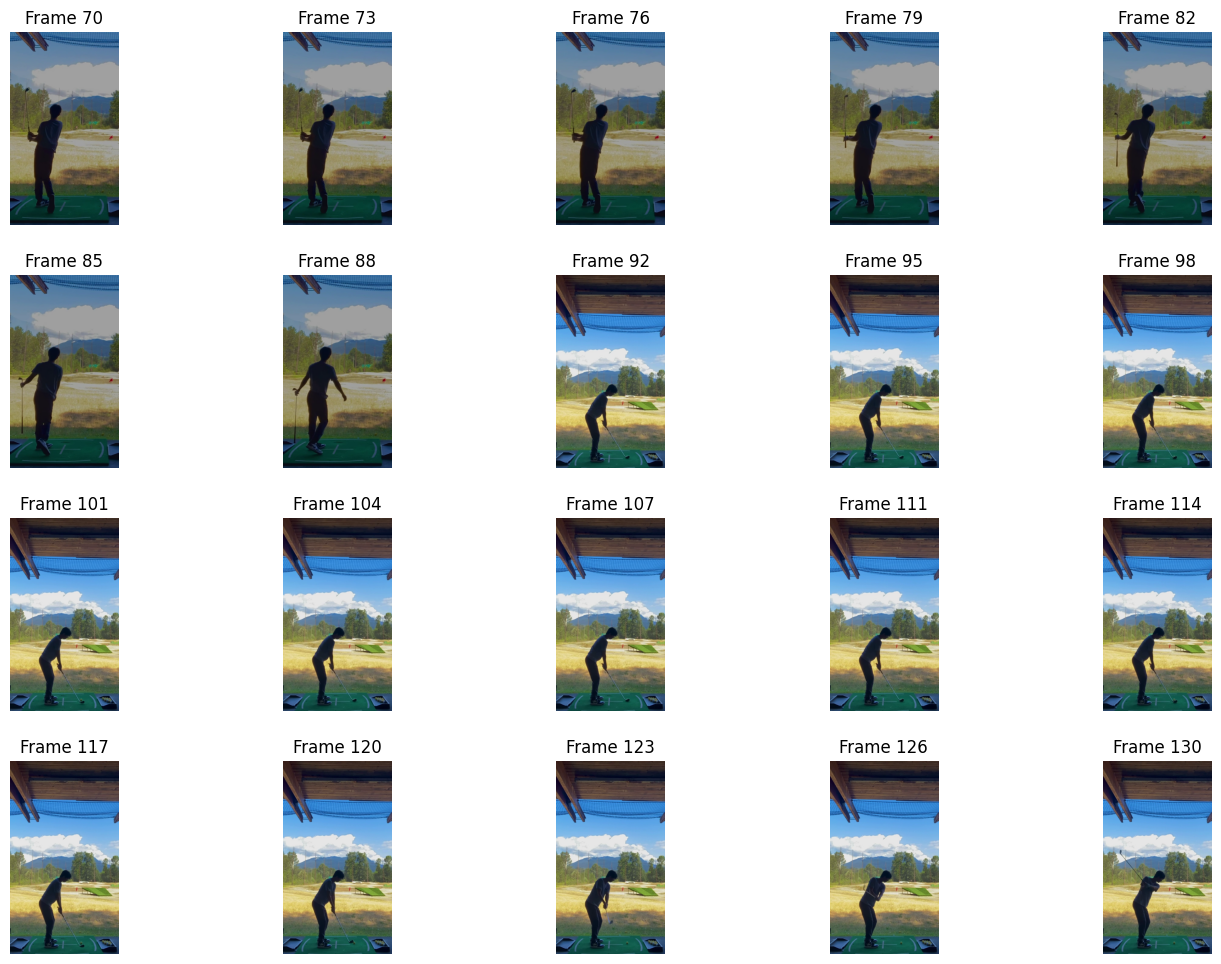

In [18]:
video_path = "input_videos/ex.mp4"
start_frame = 70
end_frame = 130
num_frames = 20

plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)
fig.show()

I am not sure why, but it seems like the coords in the plot are not matching the videos. Let me save the video with bounded boxes. To do so, i need to use render_boxes functions with arguments supplied using functools.partials

In [21]:
# # import the InferencePipeline interface
# from inference import InferencePipeline
# # import a built-in sink called render_boxes (sinks are the logic that happens after inference)
# from inference.core.interfaces.stream.sinks import render_boxes
# from inference.core.interfaces.camera.entities import VideoFrame
# import os
# import json
# from pprint import pprint

# api_key = os.getenv("ROBOFLOW_API_KEY")

# from functools import partial
# import cv2
# from inference import InferencePipeline
# from inference.core.interfaces.stream.sinks import render_boxes

# output_size = (720, 1280)
# video_sink = cv2.VideoWriter("output_videos/ex_bounded.mp4", cv2.VideoWriter_fourcc(*"MJPG"), 25.0, output_size)
# on_prediction = partial(
#     render_boxes,
#     display_size=output_size,
#     on_frame_rendered=lambda frame_data: video_sink.write(frame_data[1])
# )
    
# # create an inference pipeline object
# pipeline = InferencePipeline.init(
#     model_id="golf-49wbh/1", # set the model id to a yolov8x model with in put size 1280
#     video_reference="input_videos/ex.mp4", # set the video reference (source of video), it can be a link/path to a video file, an RTSP stream url, or an integer representing a device id (usually 0 for built in webcams)
#     on_prediction=on_prediction, # tell the pipeline object what to do with each set of inference by passing a function
#     api_key=api_key, # provide your roboflow api key for loading models from the roboflow api
# )
# # start the pipeline
# pipeline.start()
# # wait for the pipeline to finish
# pipeline.join()

Now let's use this video to compare with the trajectory plot:

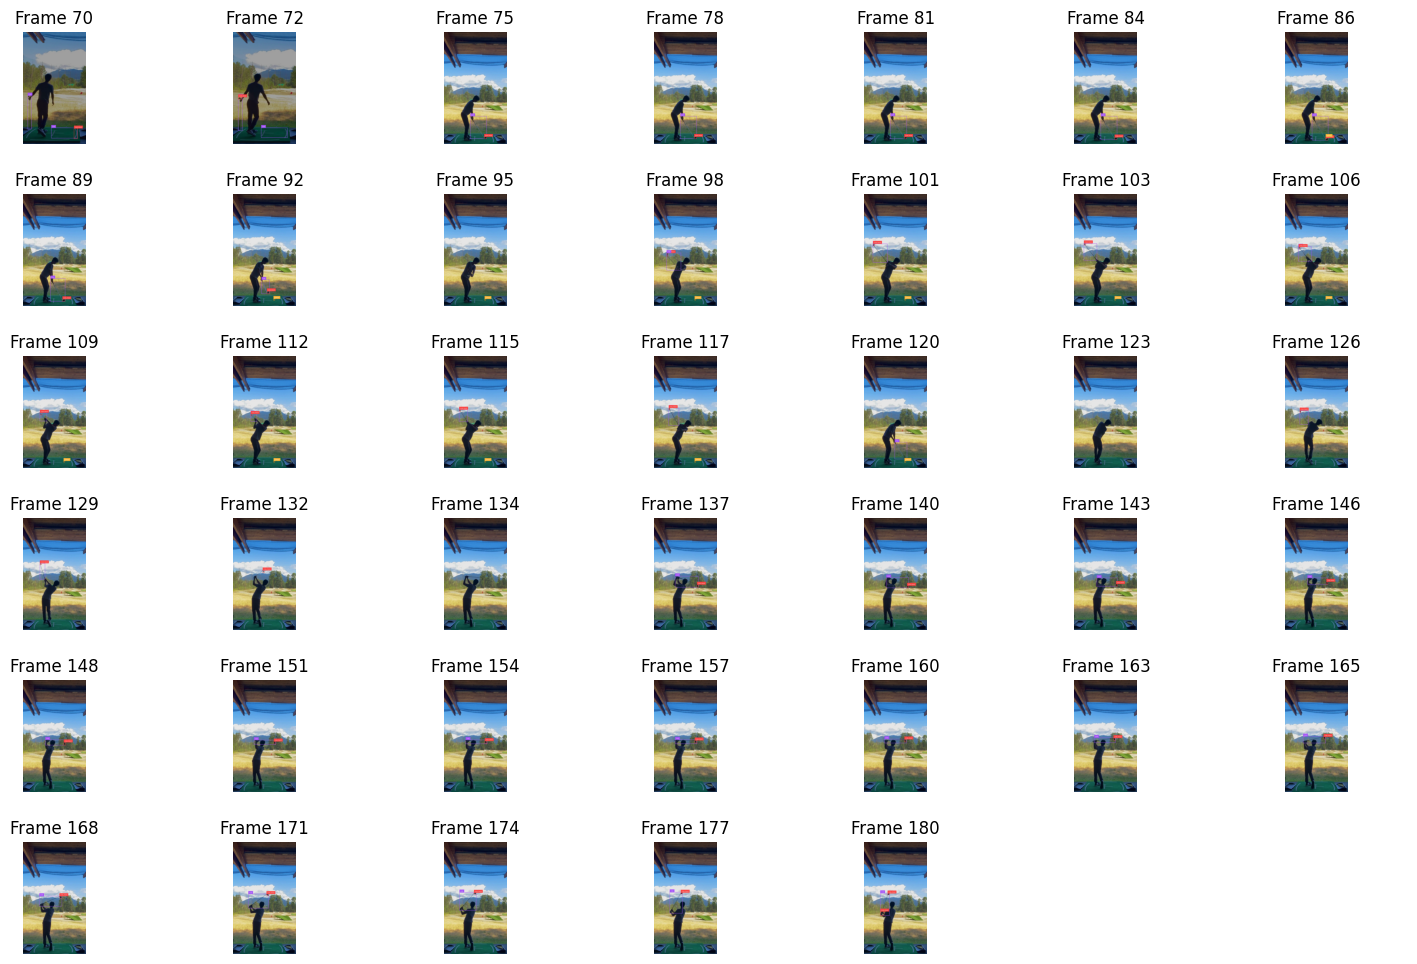

In [70]:
video_path = "output_videos/ex_bounded.mp4"
start_frame = 70
end_frame = 180
num_frames = 40

plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)
fig.show()

In [34]:
# frame_count = get_frame_count(video_path)
# print(f'Total number of frames: {frame_count}')

assert get_frame_count("input_videos/ex.mp4") == get_frame_count("output_videos/ex_bounded.mp4") == len(arr)

This is weird. Even though I checked the total frame numbers are equal to the length of the original video, they did not match. Now that I am using the output video with the bounding boxes draw, they seem to match the contents of arr correctly. I am not sure why, but we will be using the ex_bounded for now.

## Inference on a full Video 
Before I write the algorithm to extract a swing, I want to try the model on a full, unedited video. This example "input_videos/ex_full.mp4" illustrates the usefulness to extract the swings from a video.

### Save box rendered Video

In [62]:
# # import the InferencePipeline interface
# from inference import InferencePipeline
# # import a built-in sink called render_boxes (sinks are the logic that happens after inference)
# from inference.core.interfaces.stream.sinks import render_boxes
# from inference.core.interfaces.camera.entities import VideoFrame
# import os
# import json
# from pprint import pprint

# api_key = os.getenv("ROBOFLOW_API_KEY")

# from functools import partial
# import cv2
# from inference import InferencePipeline
# from inference.core.interfaces.stream.sinks import render_boxes

# output_size = (720, 1280)
# video_sink = cv2.VideoWriter("output_videos/ex_full_bounded.mp4", cv2.VideoWriter_fourcc(*"MJPG"), 25.0, output_size)
# on_prediction = partial(
#     render_boxes,
#     display_size=output_size,
#     on_frame_rendered=lambda frame_data: video_sink.write(frame_data[1])
# )
    
# # create an inference pipeline object
# pipeline = InferencePipeline.init(
#     model_id="golf-49wbh/1", # set the model id to a yolov8x model with in put size 1280
#     video_reference="input_videos/ex_full.mp4", # set the video reference (source of video), it can be a link/path to a video file, an RTSP stream url, or an integer representing a device id (usually 0 for built in webcams)
#     on_prediction=on_prediction, # tell the pipeline object what to do with each set of inference by passing a function
#     api_key=api_key, # provide your roboflow api key for loading models from the roboflow api
# )
# # start the pipeline
# pipeline.start()
# # wait for the pipeline to finish
# pipeline.join()

#### Get data list

In [41]:
# import the InferencePipeline interface
from inference import InferencePipeline
# import a built-in sink called render_boxes (sinks are the logic that happens after inference)
from inference.core.interfaces.stream.sinks import render_boxes
from inference.core.interfaces.camera.entities import VideoFrame
import os
import json
from pprint import pprint

TARGET_DIR = "predictions"
api_key = os.getenv("ROBOFLOW_API_KEY")

full_arr = []

def save_prediction(prediction: dict, video_frame: VideoFrame) -> None:
    # pprint(prediction)
    # pprint(video_frame)
    # print("------------------------------------")
  # with open(os.path.join(TARGET_DIR, f"test.txt"), "a") as f:
    full_arr.append(prediction)
  #   json.dump(prediction, f)
  #   json.dump(video_frame, f)
    

# create an inference pipeline object
pipeline = InferencePipeline.init(
    model_id="golf-49wbh/1", # set the model id to a yolov8x model with in put size 1280
    video_reference="input_videos/02.mp4", # set the video reference (source of video), it can be a link/path to a video file, an RTSP stream url, or an integer representing a device id (usually 0 for built in webcams)
    on_prediction=save_prediction, # tell the pipeline object what to do with each set of inference by passing a function
    api_key=api_key, # provide your roboflow api key for loading models from the roboflow api
)
# start the pipeline
pipeline.start()
# wait for the pipeline to finish
pipeline.join()

c:\Users\simon\miniconda3\envs\p39\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning:

Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'

c:\Users\simon\miniconda3\envs\p39\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning:

Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'



In [54]:
len(full_arr)

1530

In [66]:
get_frame_count("output_videos/ex_full_bounded.avi")

1530

In [52]:

fig_full = create_trajectory_plot(full_arr)

In [2]:
video_path = "output_videos/ex_full_bounded.avi"
start_frame = 1350
end_frame = 1400
num_frames = 20

plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)
fig_full.show()

NameError: name 'plot_evenly_distributed_frames' is not defined